## Imports

In [55]:

from sklearn.metrics import  confusion_matrix
import spacy
import nltk

from tqdm import tqdm
import seaborn as sns
import pandas as pd
import shap
import re
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
from sklearn.metrics import classification_report
from gensim.models import KeyedVectors

from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE, SelectPercentile
from sklearn.svm import SVR
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
random_seed = 42
from xgboost import XGBClassifier
tqdm.pandas()
import scipy.stats as st

import random 
random.seed(42)


## data

### read

In [56]:
df_features = pd.read_csv('../data/processed/processed_dataset.csv')
df_features

,corpus_name,id,parent,child,label,dep,parent_text,parent_lemma,parent_pos,parent_tag,...,child_lemma,child_pos,child_tag,child_shape,child_is_alpha,child_is_stop,child_morph,child_ner,child_ner_start_end,parent_ner_start_end
0,sci,1,ter,person,:ARG0,nsubj,tem,ter,VERB,VERB,...,Meyer,PROPN,PROPN,Xxxxx,True,False,Gender=Masc|Number=Sing,PER,"[0, 1]",NaN
1,sci,4,fazer,isso,:ARG1,nao_tem_dep,feito,fazer,VERB,VERB,...,isso,PRON,PRON,Xxxx,True,True,Gender=Masc|Number=Sing|PronType=Dem,NaN,NaN,NaN
2,sci,4,fazer,universidade,:ARG3,obl,feito,fazer,VERB,VERB,...,universidade,NOUN,NOUN,xxxx,True,False,Gender=Fem|Number=Sing,NaN,NaN,NaN
3,sci,12,acontecer,isso,:ARG1,nsubj,acontece,acontecer,VERB,VERB,...,isso,PRON,PRON,xxxx,True,True,Gender=Masc|Number=Sing|PronType=Dem,NaN,NaN,NaN
4,sci,16,entender,otimista,:ARG0,nsubj,entendem,entender,VERB,VERB,...,otimista,NOUN,NOUN,xxxx,True,False,Gender=Masc|Number=Plur,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13241,PropBankBr_v1.1_Dep,propbank_3347,ser,Abram_Szajman,ARG1,nao_tem_dep,é,ser,AUX,AUX,...,Abram_Szajman,PROPN,PROPN,Xxxxx_Xxxxx,False,False,Gender=Masc|Number=Sing,LOC,"[0, 1]",NaN
13242,PropBankBr_v1.1_Dep,propbank_3347,ser,presidente,ARG2,ROOT,é,ser,AUX,AUX,...,presidente,NOUN,NOUN,xxxx,True,False,Gender=Masc|Number=Sing,NaN,NaN,NaN
13243,PropBankBr_v1.1_Dep,propbank_3348,surpreender,que,ARG0,nsubj,surpreendeu,surpreender,VERB,VERB,...,que,PRON,PRON,xxx,True,True,Gender=Masc|Number=Sing|PronType=Rel,NaN,NaN,NaN
13244,PropBankBr_v1.1_Dep,propbank_3348,surpreender,galera,ARG1,obj,surpreendeu,surpreender,VERB,VERB,...,galera,NOUN,NOUN,xxxx,True,False,Gender=Fem|Number=Sing,NaN,NaN,NaN


In [57]:
df_features[['parent_pos', 'parent_tag', 'child_tag', 'child_tag']]

,parent_pos,parent_tag,child_tag,child_tag
0,VERB,VERB,PROPN,PROPN
1,VERB,VERB,PRON,PRON
2,VERB,VERB,NOUN,NOUN
3,VERB,VERB,PRON,PRON
4,VERB,VERB,NOUN,NOUN
...,...,...,...,...
13241,AUX,AUX,PROPN,PROPN
13242,AUX,AUX,NOUN,NOUN
13243,VERB,VERB,PRON,PRON
13244,VERB,VERB,NOUN,NOUN


### drop useless columns

In [58]:
# dropa colunas inuteis
df_features = df_features.drop(['parent_shape',
       'parent_is_alpha', 'parent_is_stop', 'parent_morph', 'child_shape',
       'child_is_alpha', 'child_is_stop', 'child_morph', 
       'child_ner_start_end', 'parent_ner_start_end'],axis = 1)

df_features.columns

Index(['corpus_name', 'id', 'parent', 'child', 'label', 'dep', 'parent_text',
       'parent_lemma', 'parent_pos', 'parent_tag', 'parent_ner', 'child_text',
       'child_lemma', 'child_pos', 'child_tag', 'child_ner'],
      dtype='object')

In [59]:
len(df_features.columns)

16

In [60]:
df_features.iloc[0]

corpus_name        sci
id                   1
parent             ter
child           person
label            :ARG0
dep              nsubj
parent_text        tem
parent_lemma       ter
parent_pos        VERB
parent_tag        VERB
parent_ner         NaN
child_text       Meyer
child_lemma      Meyer
child_pos        PROPN
child_tag        PROPN
child_ner          PER
Name: 0, dtype: object

### Fill nan values

In [61]:
df_features.isna().sum()

corpus_name         0
id                  0
parent              0
child               0
label               0
dep                 0
parent_text         0
parent_lemma        0
parent_pos          0
parent_tag          0
parent_ner      13148
child_text          0
child_lemma         0
child_pos           0
child_tag           0
child_ner       11989
dtype: int64

In [62]:
df_features.groupby('corpus_name').apply(lambda x: x.isna().sum())

/tmp/ipykernel_291376/2542205653.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_features.groupby('corpus_name').apply(lambda x: x.isna().sum())


,corpus_name,id,parent,child,label,dep,parent_text,parent_lemma,parent_pos,parent_tag,parent_ner,child_text,child_lemma,child_pos,child_tag,child_ner
corpus_name,,,,,,,,,,,,,,,,
PropBankBr_v1.1_Dep,0,0,0,0,0,0,0,0,0,0,10113,0,0,0,0,8982
lp,0,0,0,0,0,0,0,0,0,0,1587,0,0,0,0,1572
news,0,0,0,0,0,0,0,0,0,0,983,0,0,0,0,981
opisums,0,0,0,0,0,0,0,0,0,0,373,0,0,0,0,366
sci,0,0,0,0,0,0,0,0,0,0,92,0,0,0,0,88


In [63]:
### all nan to nsa (nao se aplica)
df_features.fillna('nsa', inplace = True)

### transform and create label

In [64]:
df_features.label.value_counts()

label
ARG1         5440
ARG0         3057
:ARG1        1517
ARG2         1413
:ARG0        1033
:ARG2         296
ARG3          151
ARG4          114
:ARG1-of       95
:ARG0-of       63
:ARG3          37
:ARG4          23
:ARG2-of        5
:ARG01-of       1
ARG5            1
Name: count, dtype: int64

In [65]:
# ################################
# # Completo 
# ################################

df_features['label'] = df_features.label.apply(
    lambda x: 
        0 if "arg0" in x.casefold() else
        1 if "arg1" in x.casefold() else
        2 if "arg2" in x.casefold() else
        3 if "arg3" in x.casefold() else
        4 if "arg4" in x.casefold() else
     #  5 if "arg5" in x.casefold() else
        "erro"
        
)

print(df_features['label'].value_counts())

df_features = df_features[
    (df_features.label != 'erro')]
df_features.label.value_counts()

label
1       7052
0       4154
2       1714
3        188
4        137
erro       1
Name: count, dtype: int64


label
1    7052
0    4154
2    1714
3     188
4     137
Name: count, dtype: int64

In [66]:
df_features.groupby(['corpus_name', 'label']).size()

corpus_name          label
PropBankBr_v1.1_Dep  0        3057
                     1        5440
                     2        1413
                     3         151
                     4         114
lp                   0         642
                     1         807
                     2         111
                     3          16
                     4          12
news                 0         299
                     1         560
                     2         131
                     3          13
                     4          10
opisums              0         132
                     1         196
                     2          44
                     3           5
sci                  0          24
                     1          49
                     2          15
                     3           3
                     4           1
dtype: int64

In [67]:
df_features.label = df_features.label.astype('int')

In [68]:
df_features['stratify-column'] = df_features.apply(lambda x: str(x.corpus_name) + "_" + str(x.label), axis = 1)
df_features['stratify-column']

0                        sci_0
1                        sci_1
2                        sci_3
3                        sci_1
4                        sci_0
                 ...          
13241    PropBankBr_v1.1_Dep_1
13242    PropBankBr_v1.1_Dep_2
13243    PropBankBr_v1.1_Dep_0
13244    PropBankBr_v1.1_Dep_1
13245    PropBankBr_v1.1_Dep_1
Name: stratify-column, Length: 13245, dtype: object

### features and label

In [69]:
# separa propbank que só vai no treino
propbank_index = df_features[df_features.corpus_name == "PropBankBr_v1.1_Dep"].index.tolist()

In [70]:
X = df_features.drop(['corpus_name', 'id', 'stratify-column', "label"], axis = 1)
y = df_features['label']

In [71]:
display(X.head())
display(y.head())

,parent,child,dep,parent_text,parent_lemma,parent_pos,parent_tag,parent_ner,child_text,child_lemma,child_pos,child_tag,child_ner
0,ter,person,nsubj,tem,ter,VERB,VERB,nsa,Meyer,Meyer,PROPN,PROPN,PER
1,fazer,isso,nao_tem_dep,feito,fazer,VERB,VERB,nsa,Isso,isso,PRON,PRON,nsa
2,fazer,universidade,obl,feito,fazer,VERB,VERB,nsa,universidade,universidade,NOUN,NOUN,nsa
3,acontecer,isso,nsubj,acontece,acontecer,VERB,VERB,nsa,isso,isso,PRON,PRON,nsa
4,entender,otimista,nsubj,entendem,entender,VERB,VERB,nsa,otimistas,otimista,NOUN,NOUN,nsa


0    0
1    1
2    3
3    1
4    0
Name: label, dtype: int64

### col vectorization

In [72]:
# # Obter embeddings para as palavras em cada coluna
def get_embedding(word):
    
    # da pau quando nao tem a palavra
    try:
        return model[word]
    except Exception as e:
        return [-1000 for n in range(len_emb)] 

In [73]:
# carrega o modelo
len_emb= 300
## glove
#model = KeyedVectors.load_word2vec_format(f'../embeddings/glove_s{len_emb}.txt')
## cbow
model = KeyedVectors.load_word2vec_format(f'../embeddings/cbow_s{len_emb}.txt')

In [74]:
#######################################################
# Antigo: lemma
#######################################################
embeddings_parent = X['parent_lemma'].progress_apply(get_embedding).tolist()
X[[f"emb_{n}_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X.index)
embeddings_child = X['child_lemma'].progress_apply(get_embedding).tolist()
X[[f"emb_{n}_child" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_child, index=X.index)

X.drop(['parent', 'parent_lemma', 'child', 'child_lemma'], axis=1, inplace = True)

cat_cols = [col for col in X.columns if "emb" not in col]
X_enc = pd.get_dummies(X[cat_cols])
X_enc

X_enc[[f"emb_{n}_lemma_child" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_child, index=X_enc.index)
X_enc[[f"emb_{n}_lemma_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X_enc.index)

100%|██████████| 13245/13245 [00:00<00:00, 144390.59it/s]
/tmp/ipykernel_291376/3433010117.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[[f"emb_{n}_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X.index)
/tmp/ipykernel_291376/3433010117.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[[f"emb_{n}_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X.index)
/tmp/ipykernel_291376/3433010117.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is 

In [75]:
print(len(X_enc[X_enc[f"emb_1_lemma_parent"] == -1000]))
print(len(X_enc[X_enc[f"emb_1_lemma_child"] == -1000]))

479
1454


### Train test split

In [76]:
###############################################
# train test split com o propbank só no treino
###############################################

# Separar os índices obrigatórios para treino
X_train_obrigatorio = X_enc.loc[propbank_index]
y_train_obrigatorio = y.loc[propbank_index]

# Índices restantes
X_restante = X_enc.drop(propbank_index)
y_restante = y.drop(propbank_index)

# Dividir o restante em treino e teste
X_train_restante, X_test, y_train_restante, y_test = train_test_split(X_restante, y_restante, test_size=0.2, random_state=42, stratify=df_features.drop(propbank_index)['label'])


# Combinar os dados de treino obrigatório com os dados de treino restante
X_train = pd.concat([X_train_restante, X_train_obrigatorio])
y_train = pd.concat([y_train_restante, y_train_obrigatorio])

In [77]:
# remover features que nao variam no treino
features_std_0 = X_train.columns[X_train.std() == 0].tolist()
X_train.drop(features_std_0,axis = 1, inplace=True)
X_test.drop(features_std_0,axis = 1, inplace=True)

## Classification

### Hyperparameter tunning

In [78]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [79]:
#selector = RFE(RandomForestClassifier(random_state=random_seed), step=100, verbose = 2)
selector = SelectPercentile()
sampler = SMOTE(random_state=42)#None#RandomOverSampler(sampling_strategy='minority',random_state=random_seed)
scaler = StandardScaler()

estimator = XGBClassifier(
    device = 'cuda',
    random_state= 42
 #tree_method = 'hist',
#    sample_weights = sample_weights
    )

pipeline_steps = [
    ('scaling', scaler),
    ('selecting', selector),
    ('sampling', sampler),
    ('estimator',estimator)
    ] 



pipeline = Pipeline(steps = pipeline_steps)

In [80]:
n_classes = len(y_train.unique())

In [81]:
# # Preconfigure estimator and parameters
# params = {  
#             "estimator__n_estimators": st.randint(3, 40),
#             "estimator__max_depth": st.randint(3, 40),
#             "estimator__learning_rate": st.uniform(0.05, 0.4),
#             "estimator__colsample_bytree": st.beta(10, 1),
#             "estimator__subsample": st.beta(10, 1),
#             "estimator__gamma": st.uniform(0, 10),
#             'estimator__objective': ['multi:softmax'],
#             'estimator__eval_metric':['aucpr'],
#             "estimator__min_child_weight": st.expon(0, 50),
#             "selecting__percentile": [10,25,40,50,80],
#             "estimator__num_class": [n_classes]
            
            
#         }

# # Random Search Training with 5 folds Cross Validation
# rf_random = RandomizedSearchCV(
#     pipeline, 
#     params, 
#     cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed), 
#     verbose=4,
#     n_iter=20, 
#     random_state=42, 
#     scoring='f1_macro') 
                              
# rf_random.fit(X_train, y_train)  
# best_params = rf_random.best_params_
# best_score = rf_random.best_score_

# print('best_params', best_params)
# print('best_score', best_score)

# model = rf_random.best_estimator_

In [82]:
best_params_0_4 = {'estimator__colsample_bytree': 0.8741814405114897,
 'estimator__eval_metric': 'aucpr',
 'estimator__gamma': 1.8657005888603584,
 'estimator__learning_rate': 0.40702359939599114,
 'estimator__max_depth': 13,
 'estimator__min_child_weight': 19.603635966648525,
 'estimator__n_estimators': 30,
 'estimator__num_class': 5,
 'estimator__objective': 'multi:softmax',
 'estimator__subsample': 0.8526493722244973,
 'selecting__percentile': 10}

best_params_0_1 = {'estimator__colsample_bytree': 0.8117046387359118,
 'estimator__eval_metric': 'aucpr',
 'estimator__gamma': 0.06952130531190703,
 'estimator__learning_rate': 0.2542989210310263,
 'estimator__max_depth': 11,
 'estimator__min_child_weight': 33.16291400529039,
 'estimator__n_estimators': 35,
 'estimator__num_class': 2,
 'estimator__objective': 'multi:softmax',
 'estimator__subsample': 0.9336160224397914,
 'selecting__percentile': 40}

model = pipeline.set_params(**best_params_0_4)
model.fit(X_train, y_train)

Pipeline(steps=[('scaling', StandardScaler()),
                ('selecting', SelectPercentile()),
                ('sampling', SMOTE(random_state=42)),
                ('estimator',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8741814405114897,
                               device='cuda', early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='aucpr...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.40702359939599114, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=13,
                               max_leaves=None,
                               min_child_weight=19.603635966648525, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=30, n_jobs=None, num_class=5,
                               num_parallel_tree=None, ...))])

In [83]:
# old random over sampler
# best_params_0_4 = {'estimator__colsample_bytree': 0.8741814405114897,
#  'estimator__eval_metric': 'aucpr',
#  'estimator__gamma': 1.8657005888603584,
#  'estimator__learning_rate': 0.40702359939599114,
#  'estimator__max_depth': 13,
#  'estimator__min_child_weight': 19.603635966648525,
#  'estimator__n_estimators': 30,
#  'estimator__num_class': 5,
#  'estimator__objective': 'multi:softmax',
#  'estimator__subsample': 0.8526493722244973,
#  'selecting__percentile': 10}

# best_params_0_2 = {'estimator__colsample_bytree': 0.8117046387359118,
#  'estimator__eval_metric': 'aucpr',
#  'estimator__gamma': 0.06952130531190703,
#  'estimator__learning_rate': 0.2542989210310263,
#  'estimator__max_depth': 11,
#  'estimator__min_child_weight': 33.16291400529039,
#  'estimator__n_estimators': 35,
#  'estimator__num_class': 5,
#  'estimator__objective': 'multi:softmax',
#  'estimator__subsample': 0.9336160224397914,
#  'selecting__percentile': 40}

# best_params_0_1 = {'estimator__colsample_bytree': 0.8741814405114897,
#  'estimator__eval_metric': 'aucpr',
#  'estimator__gamma': 1.8657005888603584,
#  'estimator__learning_rate': 0.40702359939599114,
#  'estimator__max_depth': 13,
#  'estimator__min_child_weight': 19.603635966648525,
#  'estimator__n_estimators': 30,
#  'estimator__num_class': 5,
#  'estimator__objective': 'multi:softmax',
#  'estimator__subsample': 0.8526493722244973,
#  'selecting__percentile': 10}

# model = pipeline.set_params(**best_params_0_4)
# model.fit(X_train, y_train)

### predict

In [84]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

## interpretabilidade

### Classification report e confusion matrix

In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       220
           1       0.77      0.84      0.80       322
           2       0.40      0.32      0.36        60
           3       0.33      0.14      0.20         7
           4       1.00      0.20      0.33         5

    accuracy                           0.76       614
   macro avg       0.67      0.46      0.50       614
weighted avg       0.75      0.76      0.75       614



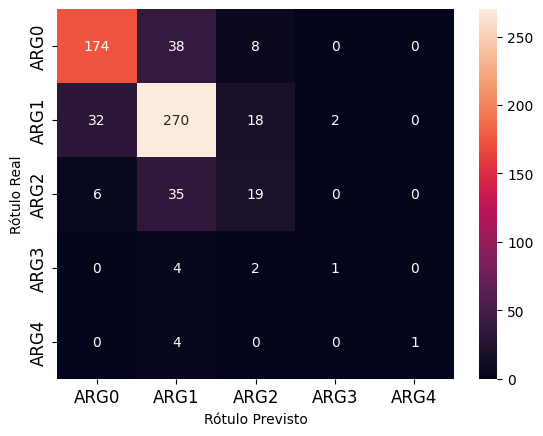

In [86]:
# Supondo que y_test e y_pred já estão definidos
cm = confusion_matrix(y_test, y_pred)

# Definir os rótulos desejados para os eixos
all_labels = [
    'ARG0', 
    'ARG1', 
    'ARG2', 
    "ARG3", 
    "ARG4"
    ]

labels = [all_labels[i] for i in range(n_classes)]

# Plotar o heatmap
ax = sns.heatmap(cm, annot=True, fmt='g')

# Definir os rótulos dos eixos
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticklabels(labels, fontsize=12)

# Exibir o plot
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Real')
plt.show()

In [87]:
286+37

323

###############################################
# corpus name: lp
###############################################
          
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       120
           1       0.81      0.82      0.81       151
           2       0.22      0.19      0.21        21
           3       0.50      0.20      0.29         5
           4       1.00      0.25      0.40         4

    accuracy                           0.79       301
   macro avg       0.68      0.47      0.51       301
weighted avg       0.78      0.79      0.78       301



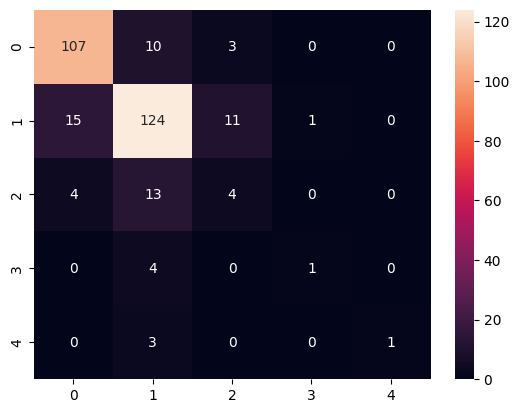

###############################################
# corpus name: news
###############################################
          
              precision    recall  f1-score   support

           0       0.77      0.68      0.73        60
           1       0.74      0.86      0.80       115
           2       0.57      0.39      0.46        31
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1

    accuracy                           0.73       208
   macro avg       0.42      0.39      0.40       208
weighted avg       0.72      0.73      0.72       208



/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

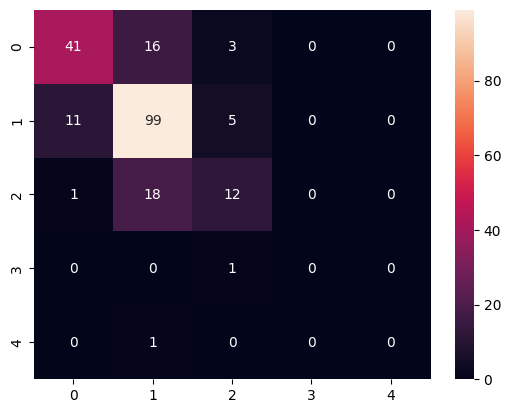

###############################################
# corpus name: opisums
###############################################
          
              precision    recall  f1-score   support

           0       0.77      0.59      0.67        34
           1       0.69      0.84      0.76        43
           2       0.29      0.29      0.29         7
           3       0.00      0.00      0.00         1

    accuracy                           0.68        85
   macro avg       0.44      0.43      0.43        85
weighted avg       0.68      0.68      0.67        85



/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

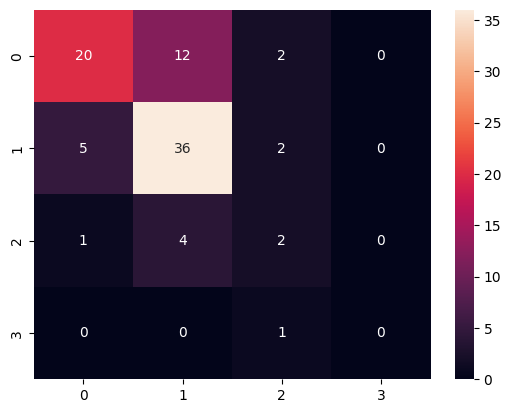

###############################################
# corpus name: sci
###############################################
          
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.85      0.92        13
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         0

    accuracy                           0.90        20
   macro avg       0.71      0.71      0.71        20
weighted avg       0.96      0.90      0.92        20



/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

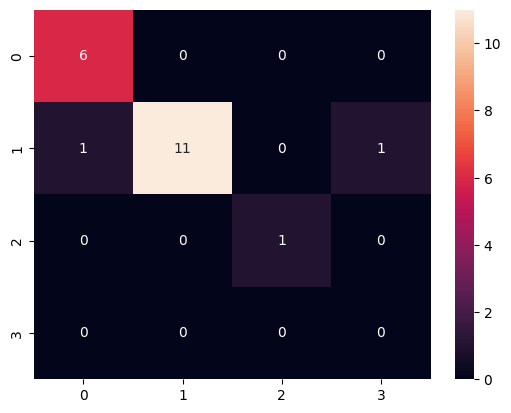

In [88]:
# Supondo que df_features, y_test e y_pred já estejam definidos
df_features_test = df_features.loc[y_test.index.tolist(), :]

df_anl = pd.DataFrame({
    "y_test": y_test.tolist(),
    "y_pred": y_pred.tolist(),
    "corpus_name": df_features.loc[y_test.index.tolist(), :]['corpus_name'].tolist(),  
})

summary_list = []

for cp_nm in df_anl.corpus_name.unique():
    
    print(f"""###############################################
# corpus name: {cp_nm}
###############################################
          """)
    
    df_anl_cp = df_anl[df_anl.corpus_name == cp_nm]
    
    # Generate the classification report
    report = classification_report(df_anl_cp.y_test, df_anl_cp.y_pred, output_dict=True)
    print(classification_report(df_anl_cp.y_test, df_anl_cp.y_pred))
    
    cm = confusion_matrix(df_anl_cp.y_test, df_anl_cp.y_pred)
    sns.heatmap(cm, annot=True, fmt='g') # font size
    plt.show()
    
    # Process each class in the report
    for label, metrics in report.items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            summary_list.append({
                'corpus_name': cp_nm,
                'classe': label,
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1-score': metrics['f1-score'],
                'support': metrics['support']
            })

# Create a summary DataFrame
df_summary = pd.DataFrame(summary_list)
df_summary.support = df_summary.support.astype("int")
df_summary.classe = df_summary.classe.astype("int")
df_summary.classe = df_summary.classe.map({
    0:'ARG0',
    1:'ARG1',
    2:'ARG2',
    3:'ARG3',
    4:'ARG4',
})

In [89]:
df_summary = df_summary.round(2)
df_summary

,corpus_name,classe,precision,recall,f1-score,support
0,lp,ARG0,0.85,0.89,0.87,120
1,lp,ARG1,0.81,0.82,0.81,151
2,lp,ARG2,0.22,0.19,0.21,21
3,lp,ARG3,0.50,0.20,0.29,5
4,lp,ARG4,1.00,0.25,0.40,4
5,news,ARG0,0.77,0.68,0.73,60
6,news,ARG1,0.74,0.86,0.80,115
7,news,ARG2,0.57,0.39,0.46,31
8,news,ARG3,0.00,0.00,0.00,1
9,news,ARG4,0.00,0.00,0.00,1


In [90]:
df_summary.to_csv('teste.csv')

###############################################
# corpus name: lp
###############################################
          
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       120
           1       0.81      0.82      0.81       151
           2       0.22      0.19      0.21        21
           3       0.50      0.20      0.29         5
           4       1.00      0.25      0.40         4

    accuracy                           0.79       301
   macro avg       0.68      0.47      0.51       301
weighted avg       0.78      0.79      0.78       301



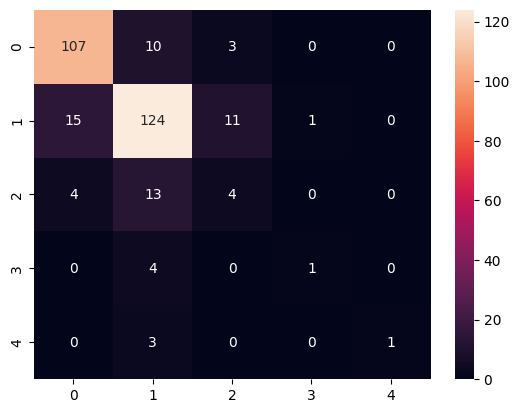

###############################################
# corpus name: news
###############################################
          
              precision    recall  f1-score   support

           0       0.77      0.68      0.73        60
           1       0.74      0.86      0.80       115
           2       0.57      0.39      0.46        31
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1

    accuracy                           0.73       208
   macro avg       0.42      0.39      0.40       208
weighted avg       0.72      0.73      0.72       208



/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

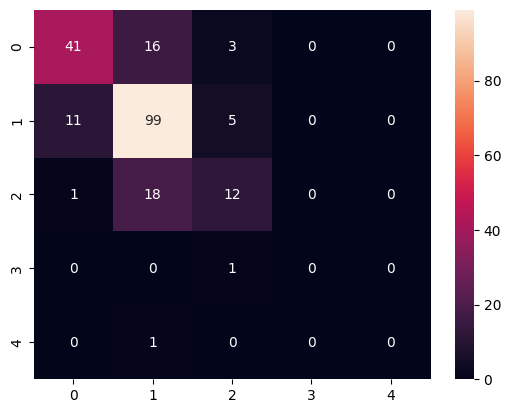

###############################################
# corpus name: opisums
###############################################
          
              precision    recall  f1-score   support

           0       0.77      0.59      0.67        34
           1       0.69      0.84      0.76        43
           2       0.29      0.29      0.29         7
           3       0.00      0.00      0.00         1

    accuracy                           0.68        85
   macro avg       0.44      0.43      0.43        85
weighted avg       0.68      0.68      0.67        85



/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

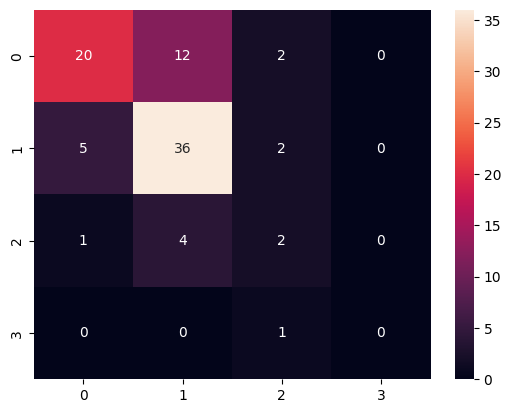

###############################################
# corpus name: sci
###############################################
          
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.85      0.92        13
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         0

    accuracy                           0.90        20
   macro avg       0.71      0.71      0.71        20
weighted avg       0.96      0.90      0.92        20



/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


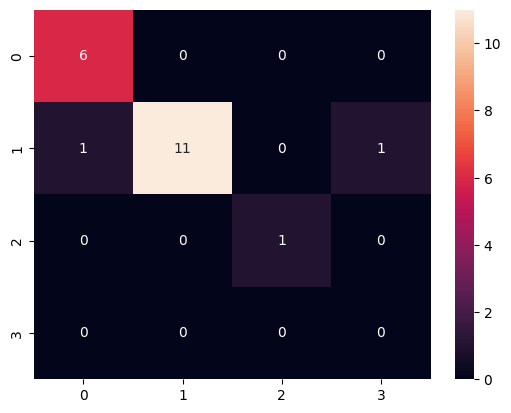

In [91]:
df_features_test = df_features.loc[y_test.index.tolist(), :]

df_anl = pd.DataFrame({
    "y_test": y_test.tolist(),
    "y_pred": y_pred.tolist(),
    "corpus_name": df_features.loc[y_test.index.tolist(), :]['corpus_name'].tolist(),  
})

for cp_nm in df_anl.corpus_name.unique():
    
    print(f"""###############################################
# corpus name: {cp_nm}
###############################################
          """)
    
    df_anl_cp = df_anl[df_anl.corpus_name == cp_nm]
    
    print(classification_report(df_anl_cp.y_test, df_anl_cp.y_pred))
    
    cm=confusion_matrix(df_anl_cp.y_test, df_anl_cp.y_pred)
    sns.heatmap(cm, annot=True, fmt='g') # font size
    plt.show()

### Featue importance

In [92]:
# # Acessar o objeto RFE na pipeline
# rfe = pipeline.named_steps['selecting']
# # Acessar o array que indica quais características foram selecionadas
# selected_features_mask = rfe.support_

selected_features_mask = model.named_steps['selecting'].get_support()

# Usar o array para filtrar os nomes das colunas do DataFrame original
selected_features = X_train.columns[selected_features_mask].tolist()

print("Características selecionadas pelo RFE:")
print(selected_features)


Características selecionadas pelo RFE:
['dep_ROOT', 'dep_advcl', 'dep_advmod', 'dep_ccomp', 'dep_conj', 'dep_iobj', 'dep_nao_tem_dep', 'dep_nsubj', 'dep_nsubj:pass', 'dep_obj', 'dep_obl', 'dep_parataxis', 'dep_xcomp', 'parent_text_,', 'parent_text_Chegamos', 'parent_text_Chegaram', 'parent_text_Confundem', 'parent_text_Da', 'parent_text_Entre', 'parent_text_Estamos', 'parent_text_Ficaram', 'parent_text_Iam', 'parent_text_Ir', 'parent_text_Li', 'parent_text_Retorna', 'parent_text_Sai', 'parent_text_Subiu', 'parent_text_Trabalhávamos', 'parent_text_Vamos', 'parent_text_Vim', 'parent_text_aberta', 'parent_text_aberto', 'parent_text_abertos', 'parent_text_aluga', 'parent_text_alugam', 'parent_text_ao', 'parent_text_apresentava', 'parent_text_assinando', 'parent_text_atuaram', 'parent_text_aumentando', 'parent_text_cair', 'parent_text_caiu', 'parent_text_caíram', 'parent_text_chega', 'parent_text_chegamos', 'parent_text_chegaram', 'parent_text_chegassem', 'parent_text_chego', 'parent_text_c

In [93]:
# forma antiga de pegar a feature original
# # Função para remover a parte após o último underscore
# def remover_apos_ultimo_underscore(s):
#     return "_".join(s.split("_")[:-1])

# original_features = [remover_apos_ultimo_underscore(feat) for feat in selected_features]

In [94]:
def get_original_feature(feature):
    
    if feature == "child_text_Desembargador": 
        print('aaaa')
    
    # resolve as features embeddings
    if "emb_" in feature:
        
        return re.sub(r'_\d+_', '_', feature)
    
    
    original_features = ['corpus_name', 'dep', 'parent_text',
        'parent_lemma', 'parent_pos', 'parent_tag', 'parent_ner', 'child_text',
        'child_lemma', 'child_pos', 'child_tag', 'child_ner', 'parent', 'child']
    
    for o_feat in original_features:
        
        if o_feat in feature:
            

            
            return o_feat
        
    return None
    

original_features = [get_original_feature(feat) for feat in selected_features]

# Extrair o modelo XGBClassifier da pipeline
xgb_model = model.named_steps['estimator']

# Obter as importâncias das características
feature_importances = xgb_model.feature_importances_

# Criar um DataFrame para facilitar a manipulação e visualização
feature_importance_df = pd.DataFrame({
    'feature': selected_features,
    "original_feature": original_features,
    'importance': feature_importances
})

In [95]:
for idx, row in feature_importance_df.iterrows():
    
    print(row.feature,"|", row.original_feature)

dep_ROOT | dep
dep_advcl | dep
dep_advmod | dep
dep_ccomp | dep
dep_conj | dep
dep_iobj | dep
dep_nao_tem_dep | dep
dep_nsubj | dep
dep_nsubj:pass | dep
dep_obj | dep
dep_obl | dep
dep_parataxis | dep
dep_xcomp | dep
parent_text_, | parent_text
parent_text_Chegamos | parent_text
parent_text_Chegaram | parent_text
parent_text_Confundem | parent_text
parent_text_Da | parent_text
parent_text_Entre | parent_text
parent_text_Estamos | parent_text
parent_text_Ficaram | parent_text
parent_text_Iam | parent_text
parent_text_Ir | parent_text
parent_text_Li | parent_text
parent_text_Retorna | parent_text
parent_text_Sai | parent_text
parent_text_Subiu | parent_text
parent_text_Trabalhávamos | parent_text
parent_text_Vamos | parent_text
parent_text_Vim | parent_text
parent_text_aberta | parent_text
parent_text_aberto | parent_text
parent_text_abertos | parent_text
parent_text_aluga | parent_text
parent_text_alugam | parent_text
parent_text_ao | parent_text
parent_text_apresentava | parent_text
pa

In [96]:
feature_importance_df.original_feature.value_counts()

original_feature
emb_lemma_child     300
emb_lemma_parent    300
parent_text         158
child_text           90
dep                  13
child_pos            10
child_tag            10
child_ner             5
parent_pos            3
parent_tag            3
Name: count, dtype: int64

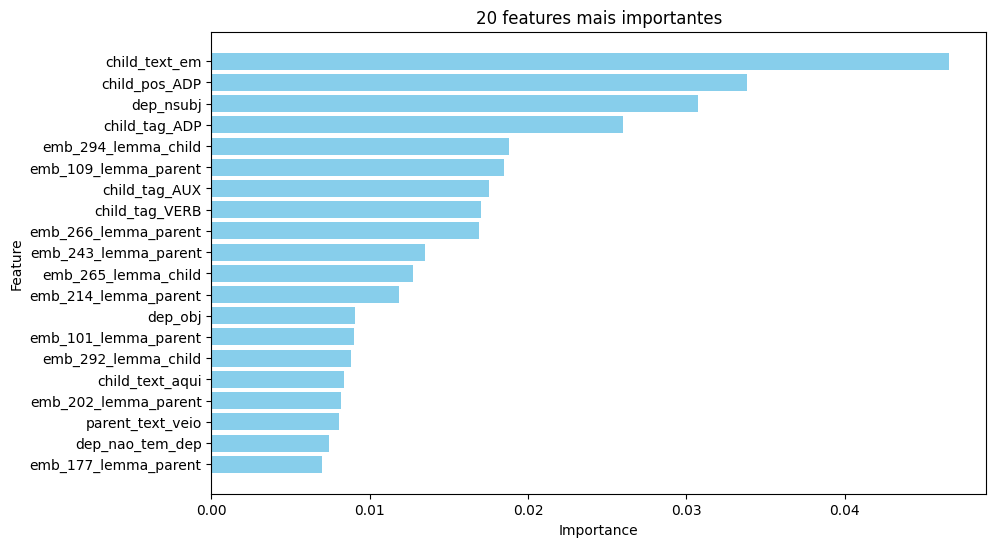

In [97]:
# Ordenar o DataFrame pelo valor de importância
top_n = 20
top_features = feature_importance_df.sort_values(by='importance', ascending=False).head(top_n)

# Plotar o gráfico de barras das principais características
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'{top_n} features mais importantes')
plt.gca().invert_yaxis()  # Inverter o eixo y para mostrar a característica mais importante no topo
plt.show()


In [109]:
if n_classes == 2:
    feature_importance_df.to_csv('importances_exp_1.csv')
elif n_classes == 5:
    feature_importance_df.to_csv('importances_exp_2.csv')

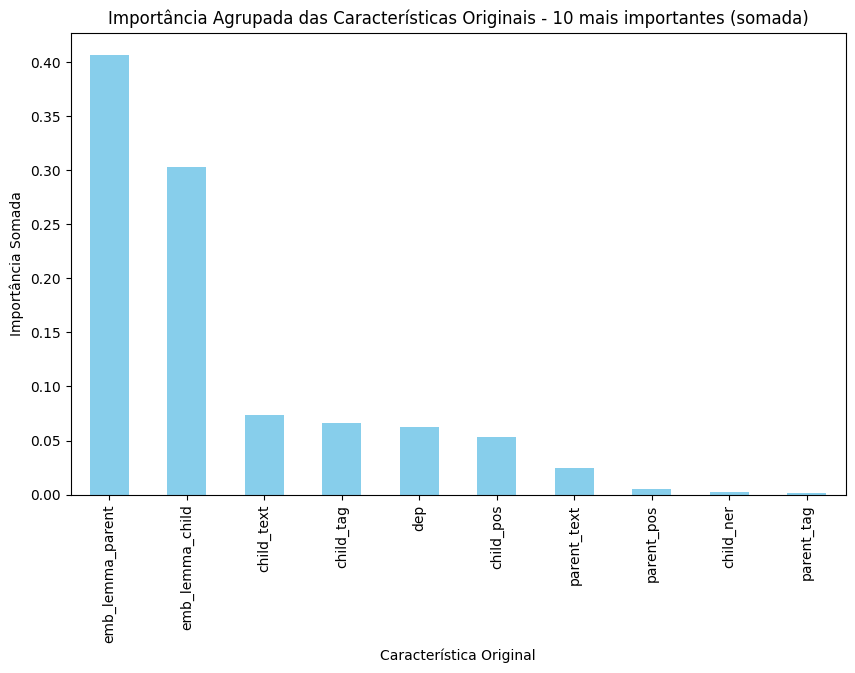

In [99]:
grouped_importances = feature_importance_df.groupby('original_feature')['importance'].sum().sort_values(ascending=False)
# Plotar o gráfico das características originais mais importantes
plt.figure(figsize=(10, 6))
top_n = 10
grouped_importances.head(top_n).plot(kind='bar', color='skyblue')
plt.title(f'Importância Agrupada das Características Originais - {top_n} mais importantes (somada)')
plt.xlabel('Característica Original')
plt.ylabel('Importância Somada')
plt.show()

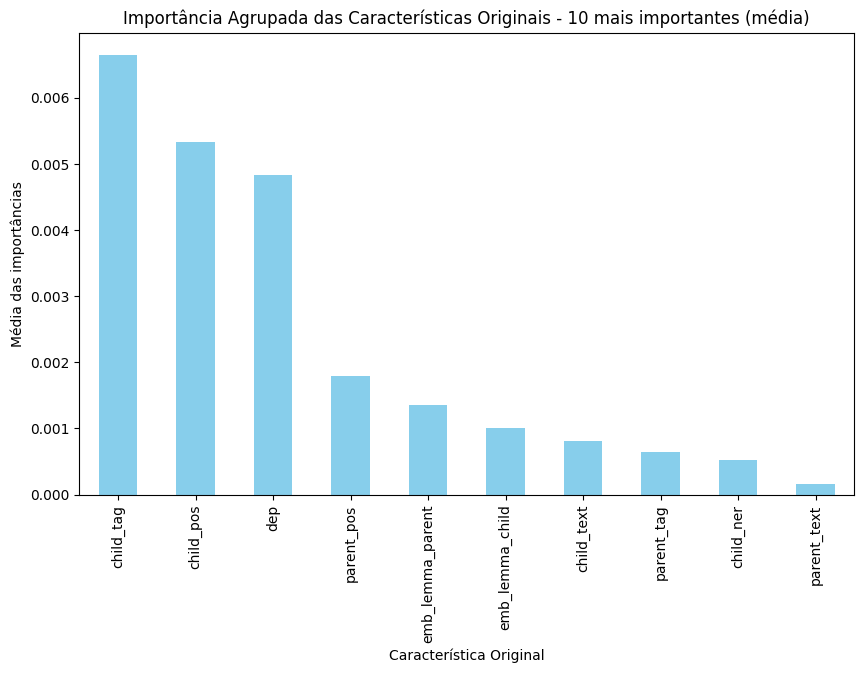

In [100]:
grouped_importances = feature_importance_df.groupby('original_feature')['importance'].mean().sort_values(ascending=False)
# Plotar o gráfico das características originais mais importantes
plt.figure(figsize=(10, 6))
top_n = 10
grouped_importances.head(top_n).plot(kind='bar', color='skyblue')
plt.title(f'Importância Agrupada das Características Originais - {top_n} mais importantes (média)')
plt.xlabel('Característica Original')
plt.ylabel('Média das importâncias')
plt.show()

### SHAP

In [101]:
X_enc

,dep_ROOT,dep_acl,dep_acl:relcl,dep_advcl,dep_advmod,dep_amod,dep_appos,dep_aux,dep_aux:pass,dep_case,...,emb_291_lemma_parent,emb_292_lemma_parent,emb_293_lemma_parent,emb_294_lemma_parent,emb_295_lemma_parent,emb_296_lemma_parent,emb_297_lemma_parent,emb_298_lemma_parent,emb_299_lemma_parent,emb_300_lemma_parent
0,False,False,False,False,False,False,False,False,False,False,...,0.278671,-0.404273,-0.119715,0.235350,0.216640,0.011861,-0.049042,0.000335,-0.080059,0.139830
1,False,False,False,False,False,False,False,False,False,False,...,0.032014,-0.141032,0.110290,0.012083,-0.007258,-0.004613,-0.014778,0.023993,-0.205071,0.068340
2,False,False,False,False,False,False,False,False,False,False,...,0.032014,-0.141032,0.110290,0.012083,-0.007258,-0.004613,-0.014778,0.023993,-0.205071,0.068340
3,False,False,False,False,False,False,False,False,False,False,...,-0.162917,0.019949,0.347596,0.259526,-0.094135,-0.018389,-0.020401,0.233729,-0.158561,0.206836
4,False,False,False,False,False,False,False,False,False,False,...,0.170762,-0.134321,0.021434,-0.017953,0.132761,0.223882,-0.270413,0.093207,-0.143554,-0.072965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13241,False,False,False,False,False,False,False,False,False,False,...,-0.093402,-0.325779,0.160753,0.393574,0.085029,0.115601,0.053970,0.015961,-0.180026,-0.035891
13242,True,False,False,False,False,False,False,False,False,False,...,-0.093402,-0.325779,0.160753,0.393574,0.085029,0.115601,0.053970,0.015961,-0.180026,-0.035891
13243,False,False,False,False,False,False,False,False,False,False,...,0.087175,-0.100272,-0.090553,-0.060146,-0.013218,0.054579,0.101700,-0.021893,-0.014914,0.247532
13244,False,False,False,False,False,False,False,False,False,False,...,0.087175,-0.100272,-0.090553,-0.060146,-0.013218,0.054579,0.101700,-0.021893,-0.014914,0.247532


In [102]:
X_enc

,dep_ROOT,dep_acl,dep_acl:relcl,dep_advcl,dep_advmod,dep_amod,dep_appos,dep_aux,dep_aux:pass,dep_case,...,emb_291_lemma_parent,emb_292_lemma_parent,emb_293_lemma_parent,emb_294_lemma_parent,emb_295_lemma_parent,emb_296_lemma_parent,emb_297_lemma_parent,emb_298_lemma_parent,emb_299_lemma_parent,emb_300_lemma_parent
0,False,False,False,False,False,False,False,False,False,False,...,0.278671,-0.404273,-0.119715,0.235350,0.216640,0.011861,-0.049042,0.000335,-0.080059,0.139830
1,False,False,False,False,False,False,False,False,False,False,...,0.032014,-0.141032,0.110290,0.012083,-0.007258,-0.004613,-0.014778,0.023993,-0.205071,0.068340
2,False,False,False,False,False,False,False,False,False,False,...,0.032014,-0.141032,0.110290,0.012083,-0.007258,-0.004613,-0.014778,0.023993,-0.205071,0.068340
3,False,False,False,False,False,False,False,False,False,False,...,-0.162917,0.019949,0.347596,0.259526,-0.094135,-0.018389,-0.020401,0.233729,-0.158561,0.206836
4,False,False,False,False,False,False,False,False,False,False,...,0.170762,-0.134321,0.021434,-0.017953,0.132761,0.223882,-0.270413,0.093207,-0.143554,-0.072965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13241,False,False,False,False,False,False,False,False,False,False,...,-0.093402,-0.325779,0.160753,0.393574,0.085029,0.115601,0.053970,0.015961,-0.180026,-0.035891
13242,True,False,False,False,False,False,False,False,False,False,...,-0.093402,-0.325779,0.160753,0.393574,0.085029,0.115601,0.053970,0.015961,-0.180026,-0.035891
13243,False,False,False,False,False,False,False,False,False,False,...,0.087175,-0.100272,-0.090553,-0.060146,-0.013218,0.054579,0.101700,-0.021893,-0.014914,0.247532
13244,False,False,False,False,False,False,False,False,False,False,...,0.087175,-0.100272,-0.090553,-0.060146,-0.013218,0.054579,0.101700,-0.021893,-0.014914,0.247532


In [103]:
X_enc.shape[1] - len(features_std_0)

8918

In [104]:
X_all = X_enc.drop(features_std_0, axis = 1)

In [105]:
# 1. Carregar o modelo treinado do pipeline
xgb_model = model.named_steps['estimator']

for step in [step[0] for step in model.steps if step[0] != "estimator"]:
    
    print(step)
    
    if step == "sampling":
        pass
    else:
        X_test_processed = model[step].transform(X_test)
        X_train_processed = model[step].transform(X_train)
        X_all_processed = model[step].transform(X_all)
        
        
df_X_test_anl = pd.DataFrame(X_test_processed, columns = selected_features)
df_X_train_anl = pd.DataFrame(X_train_processed, columns = selected_features)
df_X_all_anl = pd.DataFrame(X_all_processed, columns = selected_features)

scaling
selecting


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectPercentile was fitted without feature names
  warnings.warn(
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectPercentile was fitted without feature names
  warnings.warn(
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectPercentile was fitted without feature names
  warnings.warn(


sampling


#### Tree explainer

In [106]:
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8741814405114897, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, gamma=1.8657005888603584,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.40702359939599114,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=19.603635966648525, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=30,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [107]:
# 2. Criar o objeto Explainer para o modelo XGB
explainer = shap.TreeExplainer(xgb_model)

# 3. Calcular os SHAP values para o conjunto de teste
shap_values = explainer.shap_values(df_X_train_anl)
shap_values.shape

(12631, 892, 5)

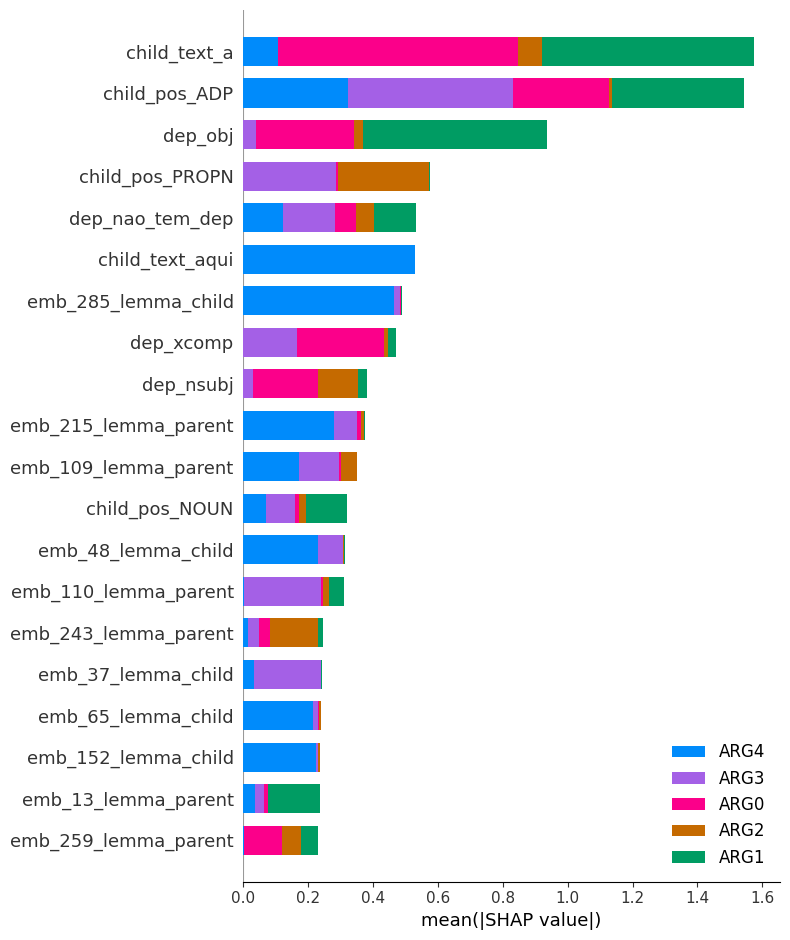

In [108]:
###################################
# plot para todas as classes não agrupado
###################################

lista = []
for  i in range(n_classes):
    
    lista.append(shap_values[:,:,i])



# Gerar o gráfico SHAP
shap.summary_plot(
    lista,
    df_X_train_anl, 
    plot_type="bar", 
    max_display=20, 
    class_names=labels,
    show=False  # Não mostrar o gráfico imediatamente
)

# Alterar o texto do eixo x
plt.gca().set_xlabel('mean(|SHAP value|)')

plt.show()

# for c in range(n_classes):
    
#     print("classe: ", c)
    
#     shap.summary_plot(shap_values[:, :, c],df_X_train_anl , plot_type="bar")
#     plt.show()